In [1]:
import numpy as np
from numpy.linalg import norm
import pickle
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm as norm_d
from scipy.stats import expon
from scipy.stats import weibull_min as weibull
from scipy.stats import burr12 as burr
from scipy.stats import randint
from scipy.stats import uniform
from scipy.optimize import minimize
import copy
import math
import time
from scipy.optimize import minimize
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals
import scipy
from sklearn.datasets import load_svmlight_file
import pickle
from pathlib import Path
from functions import *
from distrib_algs import *
from utils import *
from tests import *

%matplotlib inline

In [2]:
data_size = 32000

# Create the problem (for each value of num_of_workers run this code once)

In [ ]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
print("Datasize: ", m, ", dimension: ", n)

In [ ]:
%%time
dataset = "a9a"
num_of_workers = 1000
A, y, m, n, sparsity_A, data_split = prepare_data_distrib(dataset, data_size, num_of_workers)
print("New datasize: ", m, ", dimension: ", n)
L, average_L, worst_L = compute_L_distrib(dataset, A)
denseA = A.toarray()
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)
print("Sparsity of A: ", sparsity_A)

In [ ]:
save_split(dataset, num_of_workers, data_split)

# Find the solution (run these cells only once!)

In [ ]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

In [ ]:
filename=dataset+"_x_init_all_ones"
x_init = np.ones(n)
l2 = L/10000
l1 = 0

In [ ]:
%%time
param = [A, y, l2, False, l1]
res_solver = minimize(F, x_init, args = param, jac=logreg_grad_plus_lasso, 
                      method='L-BFGS-B',
                      options={'maxiter':10000, 'disp':True}, tol=1e-30)

print(res_solver.success)
print(res_solver.fun)
print(res_solver)

In [ ]:
save_solution(dataset, l2, l1, np.array(res_solver.x), res_solver.fun)

# Tests with 20 workers

In [3]:
%%time
dataset = "a9a"
A, y, m, n, sparsity_A = prepare_data(dataset)
A = A[0:data_size]
y = y[0:data_size]
m, n = A.shape
denseA = A.toarray()
L, average_L, worst_L = compute_L_distrib(dataset, A)
print("Datasize: ", m, ", dimension: ", n)
print("Smoothness constant of f         : ", L)
print("Average smoothness const of f_ij : ", average_L)
print("Worst smoothness const of f_ij   : ", worst_L)

num_of_workers = 20
data_split = read_split(dataset, num_of_workers)
num_of_local_data = int(m/num_of_workers)
assert(num_of_local_data == len(data_split[0]))

Datasize:  32000 , dimension:  123
Smoothness constant of f         :  1.5722182430111165
Average smoothness const of f_ij :  3.467296875001524
Worst smoothness const of f_ij   :  3.5
Wall time: 250 ms


In [4]:
shift_param = 1.0
filename=dataset+"_x_star_shifted_by_all_ones_shift_"+str(shift_param)
l2 = L/10000
l1 = 0
batch_size = 1
x_star = read_solution(dataset, l2, l1)[0]
f_star = read_solution(dataset, l2, l1)[1]
x_init = x_star + shift_param*np.ones(n)

sparse_full = False
sparse_stoch = False

In [5]:
print("f(x^0) = ", logreg_loss(x_init, [denseA,y,l2,False,0]))
print("f(x^*) = ", f_star)

f(x^0) =  8.147758896351178
f(x^*) =  0.3249566846906295


### Stochastic grad methods

In [ ]:
%%time
S = 90
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = [1, "top-1"]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 90
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = topk
sparsificator_params = [1, "top-2"]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 90
save_info_period = 10
gamma = 1.0/(L+l2)
sparsificator = identical
sparsificator_params = ["identical"]
res = ec_sgd_const_stepsize(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 30
save_info_period = 10
gamma = 1.0/(L+l2)
p = 1.0/num_of_local_data
sparsificator = topk
sparsificator_params = [1, "top-1"]
res = ec_l_svrg(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, p=p,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 30
save_info_period = 10
gamma = 1.0/(L+l2)
p = 1.0/num_of_local_data
sparsificator = topk
sparsificator_params = [1, "top-1"]
quant = randk
quant_params = [1, "rand-1"]
alpha = 1.0 / (n+1)
res = ec_l_svrg_diana(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, p=p,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, 
     quant=quant, quant_params=quant_params, alpha=alpha, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 90
save_info_period = 10
gamma = 1.0/(L+l2)
p = 1.0/num_of_local_data
sparsificator = topk
sparsificator_params = [1, "top-1"]
quant = randk
quant_params = [1, "rand-1"]
alpha = 1.0 / (n+1)
res = ec_diana_sgd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, 
     quant=quant, quant_params=quant_params, alpha=alpha, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 30
save_info_period = 10
gamma = 1.0/(L+l2)
p = 1.0/num_of_local_data
sparsificator = topk
sparsificator_params = [1, "top-1"]
quant = quantization
quant_params = [2, "l2"]
alpha = 1.0 / (np.sqrt(n)+2)
res = ec_l_svrg_diana(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma, p=p,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, 
     quant=quant, quant_params=quant_params, alpha=alpha, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

In [ ]:
%%time
S = 90
save_info_period = 10
gamma = 1.0/(L+l2)
p = 1.0/num_of_local_data
sparsificator = topk
sparsificator_params = [1, "top-1"]
quant = quantization
quant_params = [2, "l2"]
alpha = 1.0 / (np.sqrt(n)+2)
res = ec_diana_sgd(filename=filename, x_init=x_init, A=A, y=y, gamma=gamma,
     sparsificator=sparsificator, sparsificator_params=sparsificator_params, 
     quant=quant, quant_params=quant_params, alpha=alpha, data_split=data_split, 
     l2=l2, 
     sparse_full=sparse_full, sparse_stoch=sparse_stoch, 
     S=S, max_t=np.inf,
     batch_size=batch_size, save_info_period=save_info_period, 
     x_star=x_star, f_star=f_star)

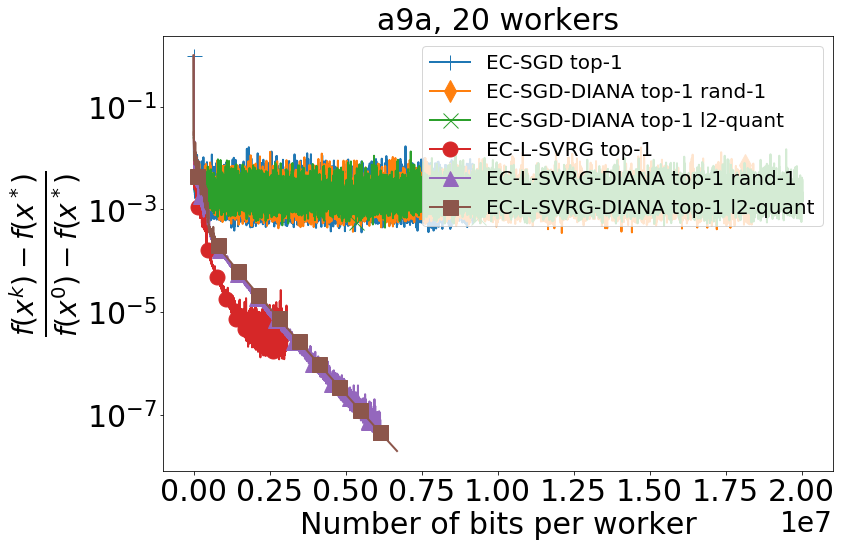

In [14]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "top-1"], 
           'EC-SGD top-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(n+1), l2, 90, num_of_workers, "top-1", "rand-1"], 
           'EC-SGD-DIANA top-1 rand-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(np.sqrt(n)+2), l2, 90, num_of_workers, "top-1", "l2"], 
           'EC-SGD-DIANA top-1 l2-quant', None],
    ['EC_L-SVRG', [1.0/(L+l2), l2, p, 30, num_of_workers, "top-1"], 
           'EC-L-SVRG top-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(n+1), p, 30, num_of_workers, "top-1", "rand-1"], 
           'EC-L-SVRG-DIANA top-1 rand-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(np.sqrt(n)+2), p, 30, num_of_workers, "top-1", "l2"], 
           'EC-L-SVRG-DIANA top-1 l2-quant', None],
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd"+filename+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_bits.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

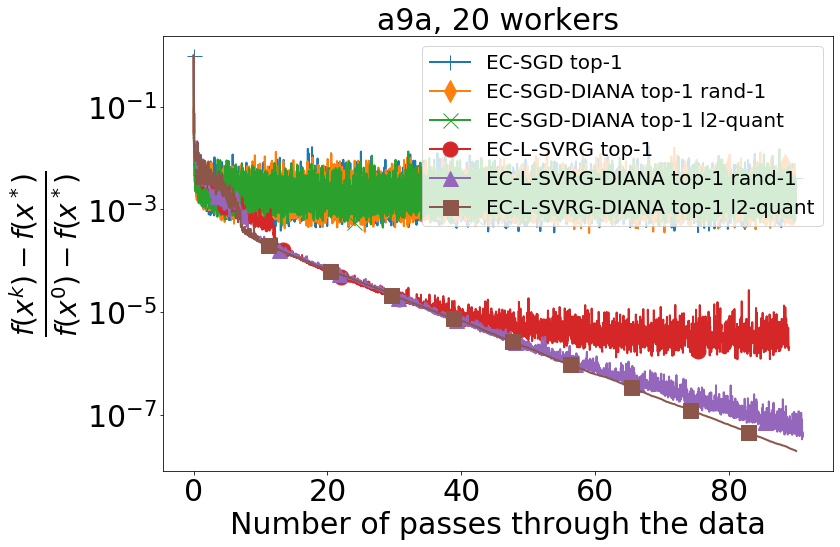

In [11]:
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "top-1"], 
           'EC-SGD top-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(n+1), l2, 90, num_of_workers, "top-1", "rand-1"], 
           'EC-SGD-DIANA top-1 rand-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(np.sqrt(n)+2), l2, 90, num_of_workers, "top-1", "l2"], 
           'EC-SGD-DIANA top-1 l2-quant', None],
    ['EC_L-SVRG', [1.0/(L+l2), l2, p, 30, num_of_workers, "top-1"], 
           'EC-L-SVRG top-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(n+1), p, 30, num_of_workers, "top-1", "rand-1"], 
           'EC-L-SVRG-DIANA top-1 rand-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(np.sqrt(n)+2), p, 30, num_of_workers, "top-1", "l2"], 
           'EC-L-SVRG-DIANA top-1 l2-quant', None],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd"+filename+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_data_passes.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

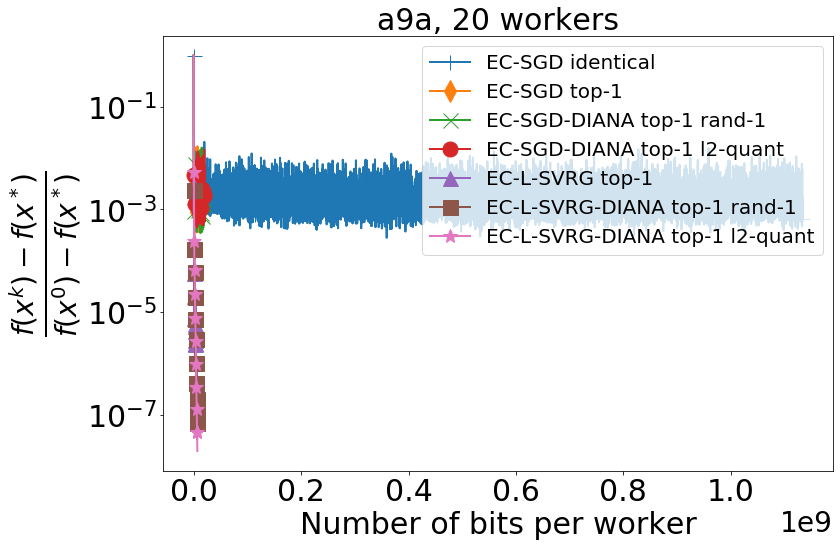

In [12]:
p = 1.0/num_of_local_data
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "identical"], 
           'EC-SGD identical', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "top-1"], 
           'EC-SGD top-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(n+1), l2, 90, num_of_workers, "top-1", "rand-1"], 
           'EC-SGD-DIANA top-1 rand-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(np.sqrt(n)+2), l2, 90, num_of_workers, "top-1", "l2"], 
           'EC-SGD-DIANA top-1 l2-quant', None],
    ['EC_L-SVRG', [1.0/(L+l2), l2, p, 30, num_of_workers, "top-1"], 
           'EC-L-SVRG top-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(n+1), p, 30, num_of_workers, "top-1", "rand-1"], 
           'EC-L-SVRG-DIANA top-1 rand-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(np.sqrt(n)+2), p, 30, num_of_workers, "top-1", "l2"], 
           'EC-L-SVRG-DIANA top-1 l2-quant', None],
]
mode_y = 'func_vals'
mode_x = 'bits'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd"+filename+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_bits_id.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)

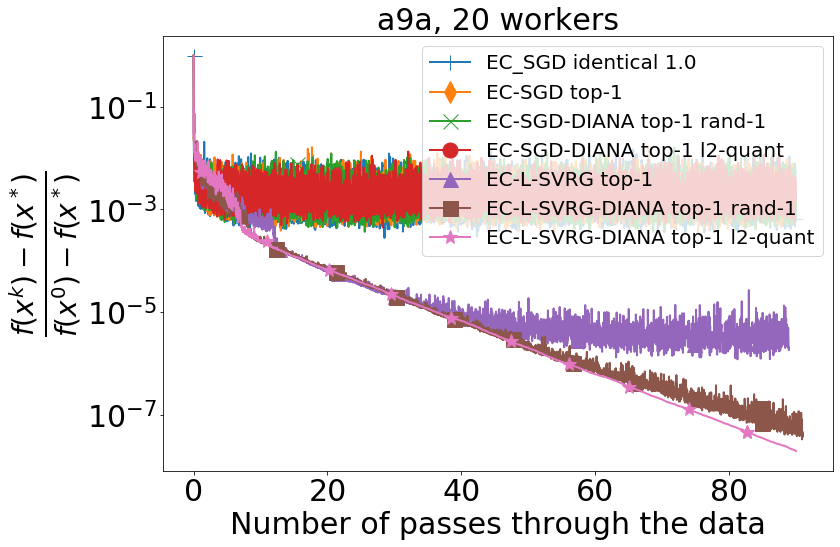

In [13]:
methods = [
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "identical"], 
           'EC_SGD identical 1.0', None],
    ['EC_SGD_const_stepsize', [1.0/(L+l2), l2, 90, num_of_workers, "top-1"], 
           'EC-SGD top-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(n+1), l2, 90, num_of_workers, "top-1", "rand-1"], 
           'EC-SGD-DIANA top-1 rand-1', None],
    ['EC_DIANA_SGD', [1.0/(L+l2), 1.0/(np.sqrt(n)+2), l2, 90, num_of_workers, "top-1", "l2"], 
           'EC-SGD-DIANA top-1 l2-quant', None],
    ['EC_L-SVRG', [1.0/(L+l2), l2, p, 30, num_of_workers, "top-1"], 
           'EC-L-SVRG top-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(n+1), p, 30, num_of_workers, "top-1", "rand-1"], 
           'EC-L-SVRG-DIANA top-1 rand-1', None],
    ['EC_L-SVRG-DIANA', [1.0/(L+l2), l2, 1.0/(np.sqrt(n)+2), p, 30, num_of_workers, "top-1", "l2"], 
           'EC-L-SVRG-DIANA top-1 l2-quant', None],
]
mode_y = 'func_vals'
mode_x = 'data_passes'
figsize = (12, 8)
title_size = 30
linewidth = 2
markersize = 15
legend_size = 20
xlabel_size = 30
ylabel_size = 40
xticks_size = 30
yticks_size = 30
sizes = [title_size, linewidth, markersize, legend_size, xlabel_size, ylabel_size, xticks_size, yticks_size]
title = dataset+", "+str(num_of_workers)+" workers"
bbox_to_anchor = (1,1)
legend_loc="upper right"


save_fig = [True, "sgd"+filename+"_l2_"+str(l2)+"_num_of_workers_"+str(num_of_workers)+"_data_passes_id.pdf"]

args_for_plots = [filename, mode_y, mode_x, figsize, sizes, title, methods, bbox_to_anchor, legend_loc, save_fig]
make_plots(args_for_plots)